In [1]:
import os
from typing import Literal
import torch
from torchvision.transforms import v2
from torchvision.io import decode_image
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import segmentation_models_pytorch as smp
from torchmetrics.classification import MulticlassAccuracy, MulticlassJaccardIndex, MulticlassF1Score
from torch.utils.tensorboard import SummaryWriter
import pandas as pd
from tqdm.notebook import tqdm
# import numpy as np

In [2]:
classes_df = pd.read_csv("city_scapes.csv")
classes = torch.tensor(classes_df[["r", "g", "b", "a"]].values, dtype=torch.uint8)

In [3]:
class SegmentationDataset(Dataset):
    def __init__(self, image_dir: str, label_dir: str, dataset_type: Literal["train", "test", "val"], transform=None, target_transform=None):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.transform = transform
        self.target_transform = target_transform
        self.city_names_label = os.listdir(label_dir)
        if dataset_type == "train":
            self.image_names = tuple(
                os.path.join(city_name, image_name)
                for city_name in os.listdir(image_dir)
                for image_name in os.listdir(os.path.join(image_dir, city_name))[:-2]
            )
            self.label_names = tuple(
                os.path.join(city_name, image_name)
                for city_name in os.listdir(label_dir)
                for image_name in os.listdir(os.path.join(label_dir, city_name))[:-8]
                if image_name.endswith("r.png")
            )
        elif dataset_type == "test":
            self.image_names = tuple(
                os.path.join(city_name, image_name)
                for city_name in os.listdir(image_dir)
                for image_name in os.listdir(os.path.join(image_dir, city_name))[-2:]
            )
            self.label_names = tuple(
                os.path.join(city_name, image_name)
                for city_name in os.listdir(label_dir)
                for image_name in os.listdir(os.path.join(label_dir, city_name))[-8:]
                if image_name.endswith("r.png")
            )
        else:
            self.image_names = tuple(
                os.path.join(city_name, image_name)
                for city_name in os.listdir(image_dir)
                for image_name in os.listdir(os.path.join(image_dir, city_name))
            )
            self.label_names = tuple(
                os.path.join(city_name, image_name)
                for city_name in os.listdir(label_dir)
                for image_name in os.listdir(os.path.join(label_dir, city_name))
                if image_name.endswith("r.png")
            )

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_names[idx])
        label_path = os.path.join(self.label_dir, self.label_names[idx])
        image = decode_image(img_path)[:, ::4, ::8]
        label = decode_image(label_path)[:, ::4, ::8]

        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)

        label_class = torch.empty(size=(label.shape[1], label.shape[2]), dtype=torch.long)
        label = label.permute(1, 2, 0)
        for class_idx, rgb in enumerate(classes):
            label_class[(label == rgb).all(dim=-1)] = class_idx

        return image, label_class, label

In [4]:
transform = v2.Compose([
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
label_transform = v2.Compose([
    v2.ToDtype(torch.uint8, scale=False)
])

In [5]:
train_dataset = SegmentationDataset(
    image_dir="leftImg8bit_trainvaltest/leftImg8bit/train",
    label_dir="gtFine_trainvaltest/gtFine/train",
    dataset_type="train",
    transform=transform,
    target_transform=label_transform
)

test_dataset = SegmentationDataset(
    image_dir="leftImg8bit_trainvaltest/leftImg8bit/train",
    label_dir="gtFine_trainvaltest/gtFine/train",
    dataset_type="test",
    transform=transform,
    target_transform=label_transform
)

val_dataset = SegmentationDataset(
    image_dir="leftImg8bit_trainvaltest/leftImg8bit/val",
    label_dir="gtFine_trainvaltest/gtFine/val",
    dataset_type="val",
    transform=transform,
    target_transform=label_transform
)

In [6]:
len(train_dataset), len(test_dataset), len(val_dataset)

(2939, 36, 500)

In [9]:
for i in range(test_dataset.__len__()):
    print(i, torch.where(train_dataset[i][2] == classes[1]))

0 (tensor([  0,   0,   0,  ..., 255, 255, 255]), tensor([  0,   0,   0,  ..., 255, 255, 255]), tensor([0, 1, 3,  ..., 0, 1, 3]))
1 (tensor([  0,   0,   0,  ..., 255, 255, 255]), tensor([  0,   0,   0,  ..., 255, 255, 255]), tensor([0, 1, 3,  ..., 0, 1, 3]))
2 (tensor([  0,   0,   0,  ..., 255, 255, 255]), tensor([  0,   0,   0,  ..., 255, 255, 255]), tensor([0, 1, 3,  ..., 0, 1, 3]))
3 (tensor([  0,   0,   0,  ..., 255, 255, 255]), tensor([  0,   0,   0,  ..., 255, 255, 255]), tensor([0, 1, 3,  ..., 0, 1, 3]))
4 (tensor([  0,   0,   0,  ..., 255, 255, 255]), tensor([  0,   0,   0,  ..., 255, 255, 255]), tensor([0, 1, 3,  ..., 0, 1, 3]))
5 (tensor([  0,   0,   0,  ..., 255, 255, 255]), tensor([  0,   0,   0,  ..., 255, 255, 255]), tensor([0, 1, 3,  ..., 0, 1, 3]))
6 (tensor([  0,   0,   0,  ..., 255, 255, 255]), tensor([  0,   0,   0,  ..., 255, 255, 255]), tensor([0, 1, 3,  ..., 0, 1, 3]))
7 (tensor([  0,   0,   0,  ..., 255, 255, 255]), tensor([  0,   0,   0,  ..., 255, 255, 255]), te

In [53]:
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [54]:
model = smp.UnetPlusPlus(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    decoder_attention_type="scse",
    in_channels=3,
    classes=29
)

dice_loss = smp.losses.DiceLoss(mode='multiclass', from_logits=True)
ce_loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3)

In [55]:
def loss_fn(pred, target, alpha=0.5, beta=0.5):
    dice = dice_loss(pred, target)
    ce = ce_loss(pred, target)

    return alpha * dice + beta * ce

In [56]:
def train_epoch(model, loader, loss_fn, optimizer, device):
    model.train()
    epoch_loss = 0
    for images, labels, _ in loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(images)
        loss = loss_fn(outputs, labels, alpha=0.7, beta=0.3)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    return epoch_loss / len(loader)

def validate_epoch(model, loader, loss_fn, device):
    model.eval()
    epoch_loss = 0
    with torch.no_grad():
        for images, labels, _ in loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = loss_fn(outputs, labels, alpha=0.7, beta=0.3)

            epoch_loss += loss.item()

    return epoch_loss / len(loader)

In [57]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
writer = SummaryWriter("runs/City_scapes")
best_val_loss = float("inf")
num_epochs = 30
for epoch in tqdm(range(num_epochs)):
    train_loss = train_epoch(model, train_loader, loss_fn, optimizer, device)
    val_loss = validate_epoch(model, val_loader, loss_fn, device)
    scheduler.step(val_loss)

    writer.add_scalar("Loss/train", train_loss, epoch)
    writer.add_scalar("Loss/val", val_loss, epoch)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_model_cityscapes.pth")

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")
writer.close()

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1/30
Train Loss: 0.8175, Validation Loss: 0.7104
Epoch 2/30
Train Loss: 0.6286, Validation Loss: 0.5960
Epoch 3/30
Train Loss: 0.5833, Validation Loss: 0.5913
Epoch 4/30
Train Loss: 0.5520, Validation Loss: 0.5489
Epoch 5/30
Train Loss: 0.5186, Validation Loss: 0.5292
Epoch 6/30
Train Loss: 0.4933, Validation Loss: 0.5313
Epoch 7/30
Train Loss: 0.4701, Validation Loss: 0.5166
Epoch 8/30
Train Loss: 0.4464, Validation Loss: 0.5798
Epoch 9/30
Train Loss: 0.4344, Validation Loss: 0.5371
Epoch 10/30
Train Loss: 0.4209, Validation Loss: 0.5050
Epoch 11/30
Train Loss: 0.3959, Validation Loss: 0.4934
Epoch 12/30
Train Loss: 0.3877, Validation Loss: 0.4911
Epoch 13/30
Train Loss: 0.3729, Validation Loss: 0.5056
Epoch 14/30
Train Loss: 0.3690, Validation Loss: 0.5219
Epoch 15/30
Train Loss: 0.3596, Validation Loss: 0.5087
Epoch 16/30
Train Loss: 0.3458, Validation Loss: 0.4792
Epoch 17/30
Train Loss: 0.3327, Validation Loss: 0.4784
Epoch 18/30
Train Loss: 0.3237, Validation Loss: 0.4956
E

In [84]:
best_model = smp.UnetPlusPlus(
    encoder_name="resnet34",
    encoder_weights=None,
    decoder_attention_type="scse",
    in_channels=3,
    classes=29
)
best_model.load_state_dict(torch.load("best_model_cityscapes.pth", map_location=torch.device('cpu'), weights_only=True))
best_model = best_model.to(device)

In [85]:
iou_metric = MulticlassJaccardIndex(num_classes=classes.shape[0], average=None).to(device)
accuracy_metric = MulticlassAccuracy(num_classes=classes.shape[0], average=None).to(device)
dice_metric = MulticlassF1Score(num_classes=classes.shape[0], average=None).to(device)
iou_metric_best_model = MulticlassJaccardIndex(num_classes=classes.shape[0], average=None).to(device)
accuracy_metric_best_model = MulticlassAccuracy(num_classes=classes.shape[0], average=None).to(device)
dice_metric_best_model = MulticlassF1Score(num_classes=classes.shape[0], average=None).to(device)

for test_images, test_labels, _ in test_loader:
    test_images, test_labels = test_images.to(device), test_labels.to(device)
    predictions = model.predict(test_images)
    predictions_best_model = best_model.predict(test_images)

    iou_metric.update(predictions, test_labels)
    accuracy_metric.update(predictions, test_labels)
    dice_metric.update(predictions, test_labels)

    iou_metric_best_model.update(predictions, test_labels)
    accuracy_metric_best_model.update(predictions, test_labels)
    dice_metric_best_model.update(predictions, test_labels)

# print(f"Accuracy: {accuracy_metric.compute():.4f}")
# print(f"IoU Jaccard Index: {iou_metric.compute():.4f}")
# print(f"Dice_metric: {dice_metric.compute():.4f}")
print(f"Accuracy: {accuracy_metric.compute()}")
print(f"IoU: {iou_metric.compute()}")
print(f"Dice_metric: {dice_metric.compute()}")
print(f"Accuracy Best Model: {accuracy_metric_best_model.compute()}")
print(f"IoU Best Model: {iou_metric_best_model.compute()}")
print(f"Dice_metric Best Model: {dice_metric_best_model.compute()}")

Accuracy: tensor([0.9723, 0.0000, 0.8928, 0.5113, 0.6208, 0.0637, 0.0000, 0.1355, 0.1614,
        0.9578, 0.2560, 0.0000, 0.0064, 0.8864, 0.2298, 0.3464, 0.7613, 0.0000,
        0.7115, 0.0000, 0.9520, 0.2515, 0.9470, 0.1957, 0.0024, 0.3060, 0.0000,
        0.5631, 0.5549], device='cuda:0')
IoU: tensor([0.9241, 0.0000, 0.7688, 0.4107, 0.5041, 0.0270, 0.0000, 0.1243, 0.1591,
        0.8461, 0.2554, 0.0000, 0.0054, 0.8294, 0.2223, 0.2853, 0.6531, 0.0000,
        0.5983, 0.0000, 0.9015, 0.1428, 0.8519, 0.1042, 0.0013, 0.2636, 0.0000,
        0.4071, 0.3932], device='cuda:0')
Dice_metric: tensor([0.9606, 0.0000, 0.8693, 0.5823, 0.6703, 0.0526, 0.0000, 0.2212, 0.2745,
        0.9166, 0.4069, 0.0000, 0.0108, 0.9067, 0.3637, 0.4440, 0.7901, 0.0000,
        0.7487, 0.0000, 0.9482, 0.2499, 0.9200, 0.1887, 0.0027, 0.4172, 0.0000,
        0.5786, 0.5644], device='cuda:0')
Accuracy Best Model: tensor([0.9723, 0.0000, 0.8928, 0.5113, 0.6208, 0.0637, 0.0000, 0.1355, 0.1614,
        0.9578, 0.2560, 0

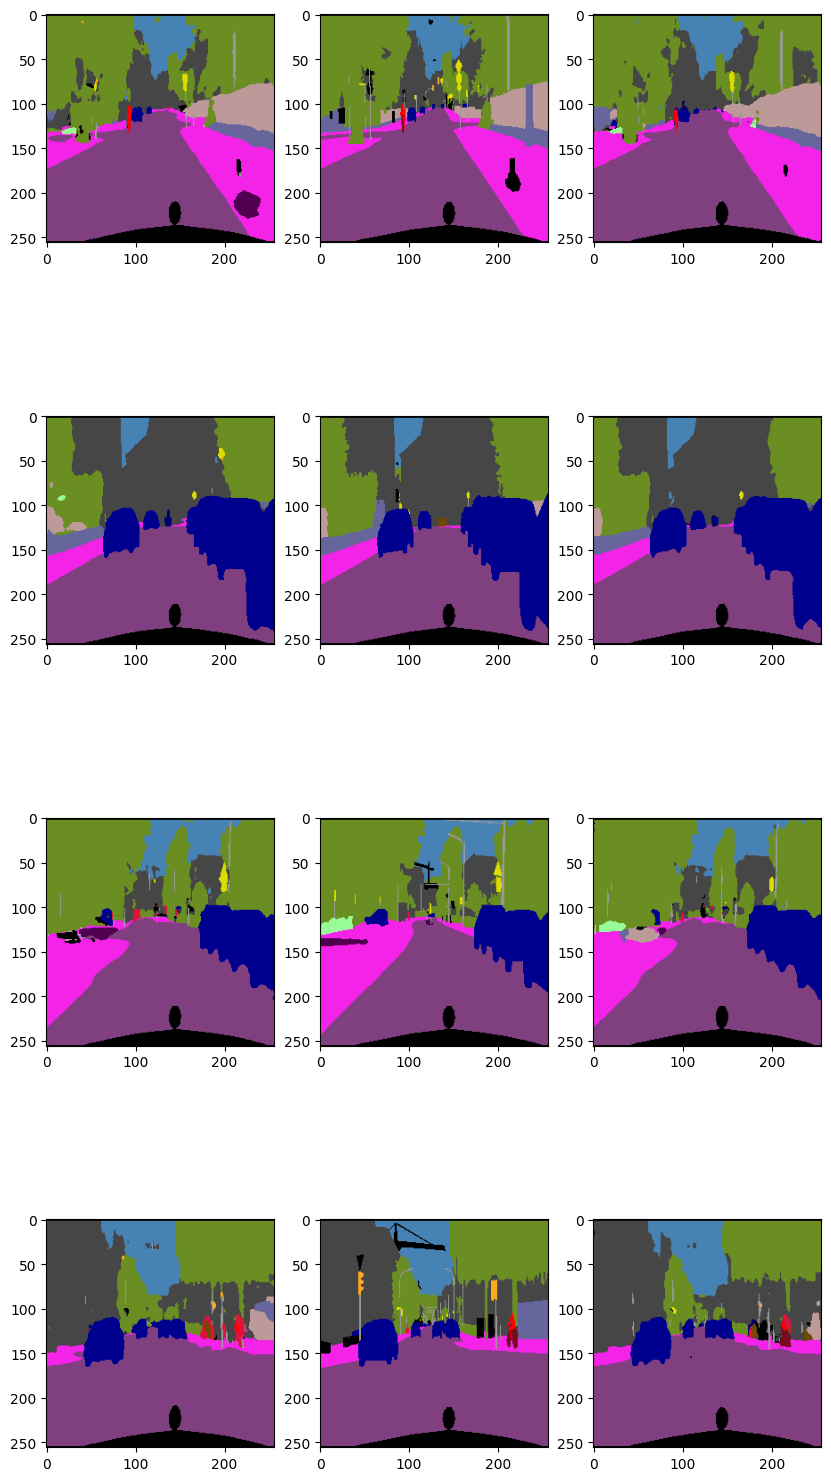

In [87]:
classes = classes.to('cpu')
class_predictions = torch.argmax(predictions, dim=1).to('cpu')
class_predictions_best = torch.argmax(predictions_best_model, dim=1).to('cpu')
fig, ax = plt.subplots(class_predictions.shape[0], 3)
fig.set_figheight(20)
fig.set_figwidth(10)
for i, pixel_class, pixel_class_best in zip(range(class_predictions.shape[0]), class_predictions, class_predictions_best):
    image = classes[pixel_class]
    image_best = classes[pixel_class_best]
    ax[i, 0].imshow(image)
    ax[i, 1].imshow(test_dataset[-class_predictions.shape[0]+i][2])
    ax[i, 2].imshow(image_best)